**Tutorial 3**

**Before running this code:** Make sure you have the following Julia packages installed: `InteractiveIsing`, `Plots`, `GLMakie`, `FileIO`.

**Install via Julia's package manager**

```julia
using Pkg
Pkg.add(url="https://github.com/rug-minds/InteractiveIsing.jl")
Pkg.add("Plots")
Pkg.add("GLMakie")
Pkg.add("FileIO")
Pkg.add("CairoMakie")
```

**What this tutorial covers:**
This tutorial demonstrates applied feild design.

- Custom feild function to simulation for different coupling patterns
- Spin glass systems with random and structured disorder

**Prerequisites:**
Please ensure you have completed Tutorial 1 to understand the basic concepts of Ising simulations and hysteresis loops.
Please ensure you have completed Tutorial 2 to understand working theory of weigh function generatior and adjency matrix. of Ising simulations and hysteresis loops.

In [ ]:
## We start a normal simulation.

using InteractiveIsing, Plots, GLMakie, FileIO
using InteractiveIsing.Processes
import InteractiveIsing as II

# Initialize a 3D Ising graph with specified dimensions and periodic boundary conditions

xL = 100  # Length in the x-dimension
yL = 100  # Length in the y-dimension
zL = 10   # Length in the z-dimension

# === Choose spin representation and boundary conditions ===
g_cont_xy = IsingGraph(xL, yL, zL, type = Continuous(), periodic = (:x,:y))
g = g_cont_xy

# === Initialize process & interface ===

# Visual marker size (tune for clarity vs performance)
II.makie_markersize[] = 0.3

# Launch interactive visualization (idle until createProcess(...) later)
interface(g)

In [ ]:
## Run same Utility as Toturail 1.
## Later we will try to make others.


## Utility functions for experiments

function newmakie(makietype, args...)
    f = makietype(args...)
    scr = GLMakie.Screen()
    display(scr, f)
    f
end

# Weight function variant 1
function weightfunc1(dx, dy, dz, rx, ry, rz)
    prefac = 1
    if (abs(dx) + abs(dy)) % 2 != 0
        prefac = 1
    else
        prefac = 1
    end
    dr2 = (rx*dx)^2 + (ry*dy)^2 + (rz*dz)^2
    return prefac / dr2
end

# Weight function variant 2
function weightfunc2(dx, dy, dz, rx, ry, rz)
    prefac = 1
    if (abs(dx) + abs(dy)) % 2 == 0
        prefac = -1
    else
        prefac = 1
    end
    dr2 = (rx*dx)^2 + (ry*dy)^2 + (rz*dz)^2
    return prefac / dr2
end


## Partition utilities

# Random partition of n into 'parts' segments (returns cumulative sizes)
function random_partition(n, parts)
    if parts == 0
        return [n]
    end
    cuts = sort(rand(1:n-1, parts-1))
    partition = [cuts[1]; diff(cuts); n - cuts[end]]
    return cumsum(partition)
end

# Uniform partition of n into 'parts' nearly equal segments (returns cumulative sizes)
function uniform_partition(n::Integer, parts::Integer)
    if parts == 0
        return [n]
    end
    base = div(n, parts)       # base size of each part
    rem = mod(n, parts)        # remainder to distribute
    partition = [i <= rem ? base + 1 : base for i in 1:parts]
    return cumsum(partition)
end

# Generate random numbers around x with range ±y
function randAround(x::Number, y::Number, dims::Int...)
    x = float(x)
    y = float(y)
    return x .+ y .* (2 .* rand(dims...) .- 1)
end


##################################################################################
### Pulse type: TrianglePulseA (simple four-segment triangular waveform)
struct TrianglePulseA end

function Processes.init(::TrianglePulseA, args)
    (;amp, numpulses, rise_point) = args
    steps = num_calls(args)

    first  = LinRange(0, amp, round(Int,rise_point))
    second = LinRange(amp, 0, round(Int,rise_point))
    third  = LinRange(0, -amp, round(Int,rise_point))
    fourth = LinRange(-amp, 0, round(Int,rise_point))
    pulse = vcat(first, second, third, fourth)
    pulse = repeat(pulse, numpulses)

    if steps < length(pulse)
        "Wrong length"
    else
        fix_num = num_calls(args) - length(pulse)
        fix_arr = zeros(Int, fix_num)
        pulse   = vcat(pulse, fix_arr)
    end

    # Predefine storage arrays
    x = Float32[]
    y = Float32[]
    processsizehint!(args, x)
    processsizehint!(args, y)

    return (;pulse, x, y)
end

function (::TrianglePulseA)(args)
    (;pulse, M, x, y, hamiltonian) = args
    pulse_val = pulse[algo_loopidx(args)]
    hamiltonian.b[] = pulse_val
    push!(x, pulse_val)
    push!(y, M[])
end


##################################################################################
### Pulse type: PUNDa (no delay time between pulses)
struct PUNDa end

function Processes.init(::PUNDa, args)
    (;amp, numpulses, rise_point) = args
    steps = num_calls(args)

    first  = LinRange(0, amp, round(Int,rise_point))
    second = LinRange(amp, 0, round(Int,rise_point))
    third  = LinRange(0, -amp, round(Int,rise_point))
    fourth = LinRange(-amp, 0, round(Int,rise_point))
    pulse = vcat(first, second, first, second, third, fourth, third, fourth)
    pulse = repeat(pulse, numpulses)

    if steps < length(pulse)
        println("Pulse is longer than lifetime")
    else
        fix_num = num_calls(args) - length(pulse)
        fix_arr = zeros(Int, fix_num)
        pulse   = vcat(pulse, fix_arr)
    end

    # Predefine storage arrays
    x = Float32[]
    y = Float32[]
    all_Es = Float32[]
    processsizehint!(args, x)
    processsizehint!(args, y)

    return (;pulse, x, y)
end

function (::PUNDa)(args)
    (;pulse, M, x, y, hamiltonian) = args
    pulse_val = pulse[algo_loopidx(args)]
    hamiltonian.b[] = pulse_val
    push!(x, pulse_val)
    push!(y, M[])
end


##################################################################################
### Pulse type: PUNDb (with delay time between each pulse)
struct PUNDb end

function Processes.init(::PUNDb, args)
    (;amp, numpulses, rise_point) = args
    steps = num_calls(args)

    delay  = zeros(Int, rise_point)
    first  = LinRange(0, amp, round(Int,rise_point))
    amp1   = fill(amp, rise_point)
    second = LinRange(amp, 0, round(Int,rise_point))
    third  = LinRange(0, -amp, round(Int,rise_point))
    amp2   = fill(-amp, rise_point)
    fourth = LinRange(-amp, 0, round(Int,rise_point))

    pulse = vcat(delay, first, amp1, second,
                 delay, first, amp1, second,
                 delay, third, amp2, fourth,
                 delay, third, amp2, fourth)

    pulse = repeat(pulse, numpulses)

    if steps < length(pulse)
        println("Pulse is longer than lifetime")
    else
        fix_num = num_calls(args) - length(pulse)
        fix_arr = zeros(Int, fix_num)
        pulse   = vcat(pulse, fix_arr)
    end

    # Predefine storage arrays
    x = Float32[]
    y = Float32[]
    all_Es = Float32[]
    processsizehint!(args, x)
    processsizehint!(args, y)

    return (;pulse, x, y)
end

function (::PUNDb)(args)
    (;pulse, M, x, y, hamiltonian) = args
    pulse_val = pulse[algo_loopidx(args)]
    hamiltonian.b[] = pulse_val
    push!(x, pulse_val)
    push!(y, M[])
end


In this toturail, we will talk about how to 

In [ ]:
x_n = random_partition(xL, 20)
y_n = random_partition(yL, 20)
z_n = random_partition(zL, 3)
coef_x =randAround(1, 0.2, 20)
coef_y =randAround(1, 0.2, 20)
coef_z =randAround(1, 0.2, 3)
println(x_n)
println(y_n)
println(z_n)
println(coef_x)
println(coef_y)
println(coef_z)


function weightfunc_glass_anti(dx, dy, dz, x, y, z, x_n, y_n,z_n, coef_x,coef_y, coef_z)
    prefac = 1
    ix = findfirst(v -> x ≤ v, x_n)
    iy = findfirst(v -> y ≤ v, y_n)
    iz = findfirst(v -> z ≤ v, z_n)
    if isnothing(ix) || isnothing(iy)
        error("out of range")
    end
    dr2 = (coef_x[ix] * dx)^2 + (coef_y[iy] * dy)^2 +(coef_z[iz]* dz)^2
    if (abs(dx) + abs(dy)) % 2 != 0  
        prefac = -1
    else  
        prefac = 1
    end
    return prefac / dr2
end

function weightfunc_glass_ferro(dx, dy, dz, x, y, z, x_n, y_n,z_n, coef_x,coef_y, coef_z)
    prefac = 1
    ix = findfirst(v -> x ≤ v, x_n)
    iy = findfirst(v -> y ≤ v, y_n)
    iz = findfirst(v -> z ≤ v, z_n)
    if isnothing(ix) || isnothing(iy)
        error("out of range")
    end
    dr2 = (coef_x[ix] * dx)^2 + (coef_y[iy] * dy)^2 +(coef_z[iz]* dz)^2
    prefac = 1
    return prefac / dr2
end

function weightfunc_AntiWithFerro(dx, dy, dz, x, y, z, x_n, y_n,z_n, coef_x, coef_y, coef_z)
    prefac = 1
    ix = findfirst(v -> x ≤ v, x_n)
    iy = findfirst(v -> y ≤ v, y_n)
    iz = findfirst(v -> z ≤ v, z_n)
    if isnothing(ix) || isnothing(iy)
        error("out of range")
    end
    dr2 = (coef_x[ix] * dx)^2 + (coef_y[iy] * dy)^2 +(coef_z[iz]* dz)^2
    if ix % 2 == 0 && iy %2==0
        prefac=1
    elseif xor(isodd(ix), isodd(iy))
        if (abs(dx) + abs(dy)) % 2 != 0  
            prefac = -1
        else  
            prefac = 1
        end
    end
    return prefac / dr2
end

wg_glass1 = @WG "(dx,dy,dz,x,y,z) -> weightfunc_glass_ferro(dx,dy,dz,x,y,z,x_n, y_n, z_n, coef_x,coef_y,coef_z)" NN = (1,1,1)
wg_glass2 = @WG "(dx,dy,dz,x,y,z) -> weightfunc_glass_anti(dx,dy,dz,x,y,z, x_n, y_n, z_n, coef_x,coef_y,coef_z)" NN = (1,1,1)
wg_glass3 = @WG "(dx,dy,dz,x,y,z) -> weightfunc_AntiWithFerro(dx, dy, dz, x, y, z, x_n, y_n, z_n, coef_x, coef_y, coef_z)" NN = (2,2,2)
genAdj!(g[1], wg_glass3)

In [ ]:
# Apply a moderate negative self-energy bias.
# This favors polarized states (ferroelectric tendency),
# making flips toward zero polarization less likely
# and stabilizing domain alignment.

homogeneousself!(g, -1)

In [ ]:
### We set Temperature to 1.5
settemp(g,1.5)

**Depolarization Field (DepolField) Explanation**

`DepolField(g; c, left_layers, right_layers)` adds an internal (depolarization) field opposing net polarization (especially along the open film direction z).  
Intuition: a polarized slab builds bound surface charge; the depolarization field tries to reduce (or split) domains to lower that electrostatic energy.

Parameter meanings:
- c: scaling / “capacitance-like” constant. In this model smaller c ⇒ stronger depolarization penalty per unit polarization (as your note says: closer to 0 → stronger DP effect). Large c weakens the depolarizing term, allowing robust ferroelectric hysteresis. Very small c can collapse loops (pinched or slim, even suppressing remanent polarization).
- left_layers, right_layers: number of surface layers (at z=1 and z=zL) included in the surface charge / boundary treatment. Increasing these effectively broadens the region contributing to the depolarizing energy (can modestly strengthen its influence).
- Resulting behavior:
  - Strong depol (small c): promotes closure or mixed ± domains, reduces remanent polarization Pr, can produce pinched or constricted loops.
  - Weak depol (large c): allows uniform single-domain switching, larger Pr and squarer loops.
  - Intermediate: tuning space for realistic, moderately slanted loops.

---

Interplay with other parameters:
- **Temperature (settemp)**
- **Self energy (homogeneousself!)**
- **Pulse amplitude:** Must exceed effective coercive field raised by strong depol. If loops look pinched at zero field, try (a) increasing amplitude, (b) increasing c, or (c) lowering depol-affected surface layer count.

---


Heuristic symptoms:
- Loop too rectangular, very high Pr: depol too weak (c too large) or pulse too strong.
- Pinched loop crossing near origin: depol relatively strong (c small) or large internal heterogeneity (defects / antiferro modulation).
- Almost zero remanence: c extremely small or temperature very high (or both).

Why call `sethomogeneousparam(g.hamiltonian, :b)` after constructing the Hamiltonian?
- Ensures the external field parameter `b` (used by pulses) is a homogeneous, mutable reference across terms so pulse processes can update `hamiltonian.b[]` efficiently.

---

Example sweep snippet (adapt to a small test size first):
```julia
for cval in (60000, 20000, 10000, 5000, 2000, 1000)
    g.hamiltonian = Ising(g) + DepolField(g, c=cval, left_layers=1, right_layers=1)
    g.hamiltonian = sethomogeneousparam(g.hamiltonian, :b)
    # run pulse process here, collect Pr, store loop metrics
end
```
---

Current cell (c=60000) chooses a relatively weak depolarization (large c) to retain clear ferroelectric switching before demonstrating stronger depol cases with smaller c later.

---

Guidelines summary:
- Increase c to restore polarization if loops are overly pinched.
- Decrease c to study depolarization-induced loop constriction or domain patterning.
- Adjust T and self energy in tandem to avoid misattributing effects (e.g. a pinched loop from high T vs strong depol).


In [ ]:
# Set depolarization (DP) field:
# Smaller c => stronger depolarization penalty (suppresses net polarization, can pinch loops)
# Larger  c => weaker depolarization (permits larger remanent polarization)
# Here: c=60000 (weak DP) for a clear baseline hysteresis loop.
g.hamiltonian = Ising(g) + DepolField(g, c=60000, left_layers=1, right_layers=1)

# Make external field parameter :b homogeneous & mutable so pulse routines can update hamiltonian.b[]
g.hamiltonian = sethomogeneousparam(g.hamiltonian, :b)

**Adjacency / coupling matrix construction**

We restrict the neighbor search to **NN = (1,1,1)**, meaning only nearest neighbors  
in ±x, ±y, ±z directions are considered (no further neighbors).


* **@WG expression**: builds a weight generator. For each valid neighbor offset (dx,dy,dz),
  it calls `weightfunc1` to compute the coupling value J(dx,dy,dz).
* **NN = (1,1,1)**: limits offsets to ±1 in each axis (nearest-neighbor stencil).
* **genAdj!(g\[1], wg1)**: traverses all lattice sites, applies the weight generator,
  and fills the sparse adjacency (interaction) matrix J used in the Ising Hamiltonian.

**Result:**

* The resulting sparse matrix contains entries J\_ij > 0, favoring aligned spins (ferroelectric / ferromagnetic tendency).
* You can inspect it with `adj(g)` or `adj(g[1])`.
* To extend range: increase `NN` (e.g. (2,2,2)).
* To change anisotropy: modify the (rx,ry,rz) arguments in `weightfunc1`.
* To introduce alternating (antiferro) couplings: switch to `weightfunc2`.

**Note**

In the next section we will discuss how to define a custom weightfunction.

In [ ]:
# Define nearest-neighbor coupling:
# NN = (1,1,1) → only ±1 neighbors in x, y, z directions
# @WG builds a weight generator using weightfunc1 with isotropic scaling (1,1,1)
# genAdj! populates the sparse adjacency (interaction) matrix for g[1], which is the graph we defined above.
wg1 = @WG "(dx,dy,dz,x,y,z) -> weightfunc1(dx,dy,dz,1,1,1)" 
NN = (1,1,1)
genAdj!(g[1], wg1)

// ...existing code...

**TrianglePulseA run explanation**

- fullsweep = xL * yL * zL  
  One sweep = one attempted Metropolis update per dipole on average.
- Time_fctr  
  Fraction of a sweep between pulse field changes; smaller ⇒ slower field evolution relative to relaxation.
- SpeedRate = Int(Time_fctr * fullsweep)  
  Number of Metropolis updates between successive pulse amplitude steps (the process call cadence).
- risepoint  
  Number of discrete amplitude steps used to ramp each linear leg of the triangular waveform.
- Amptitude  
  Peak absolute external field value (pulse height).
- PulseN  
  Number of full triangular cycles to concatenate.
- Pulsetime = (PulseN * 4 + 2) * risepoint * SpeedRate  
  Total simulation lifetime in Metropolis update calls (4 legs per cycle plus a small padding factor here).
- compalgo = CompositeAlgorithm((Metropolis, TrianglePulseA), (1, SpeedRate))  
  Interleaves: 1 Metropolis kernel executed SpeedRate times per pulse update step produced by TrianglePulseA.
- createProcess(...)  
  Allocates internal buffers, precomputes the pulse sequence, and starts the asynchronous simulation.
- est_remaining(process(g))  
  Rough wall‑clock remaining time estimate based on progress so far.
- args = process(g) |> fetch  
  Blocks until the process finishes; returns named tuple with recorded traces (x = field, y = polarization).
- inlineplot / newmakie  
  Quick visualizations of hysteresis (voltage vs Pr) and time series.

**Typical adjustments**

| Goal | Parameter to adjust | Effect |
|------|---------------------|--------|
| Smoother quasi-static loop | Increase Time_fctr | More relaxation between field increments |
| Faster field cycling | Decrease Time_fctr or risepoint | Fewer updates per ramp leg |
| Finer ramp resolution | Increase risepoint | More amplitude samples per leg |
| Stronger coercive response | Increase Amptitude (until saturation) | Extends loop width |
| Short test run | Reduce PulseN or risepoint | Shorter lifetime |

**Fetch vs getcontext**

- fetch waits for completion (safe for post‑processing).
- getcontext (if available) would let you peek mid‑run without stopping (useful for early diagnostics).

**Common pitfalls**

- If Pulsetime is too small (lifetime < needed pulse length) the pulse will be truncated (check warnings).
- Too large SpeedRate (relative to system size) can under‑sample thermal relaxation; decrease Time_fctr if dynamics lag behind the driving field.
- Extremely large Amptitude may drive immediate saturation, hiding subtle domain wall motion.

**Minimal parameter tuning recipe**

1. Choose reasonable Amptitude to reach but not excessively exceed coercive field.  
2. Set risepoint so each leg has enough steps (e.g. few hundred) for a smooth loop.  
3. Adjust Time_fctr until polarization changes appear equilibrated between steps (loop shape stable over repeats).  
4. Increase PulseN only after shape is satisfactory (to gather statistics).

**Next steps**

You can now:
- Swap TrianglePulseA for PUNDa or PUNDb without changing Metropolis settings.
- Modify temperature (settemp) or depolarization (c) to study loop morphology changes.
- Record coercive field by locating voltage values at which Pr crosses zero on ascending/descending branches.


**Summary**

The code sets up a time‑resolved loop: repeated Metropolis relaxation segments interleaved with deterministic TrianglePulseA field steps, yielding a hysteresis curve (voltage vs polarization) suitable for analyzing coercive field, remanent polarization, and rate effects.
// ...existing code...

WG: WeightGenerator with
	 NN: 				(1, 1, 1)
	 func: 				(dx,dy,dz,x,y,z) -> weightfunc1(dx,dy,dz,1,1,1)
D: 3
Base.RefValue{Float32}(0.0f0)
Estimated time to completion: 0:0:14
Of which remaining: 0:0:14


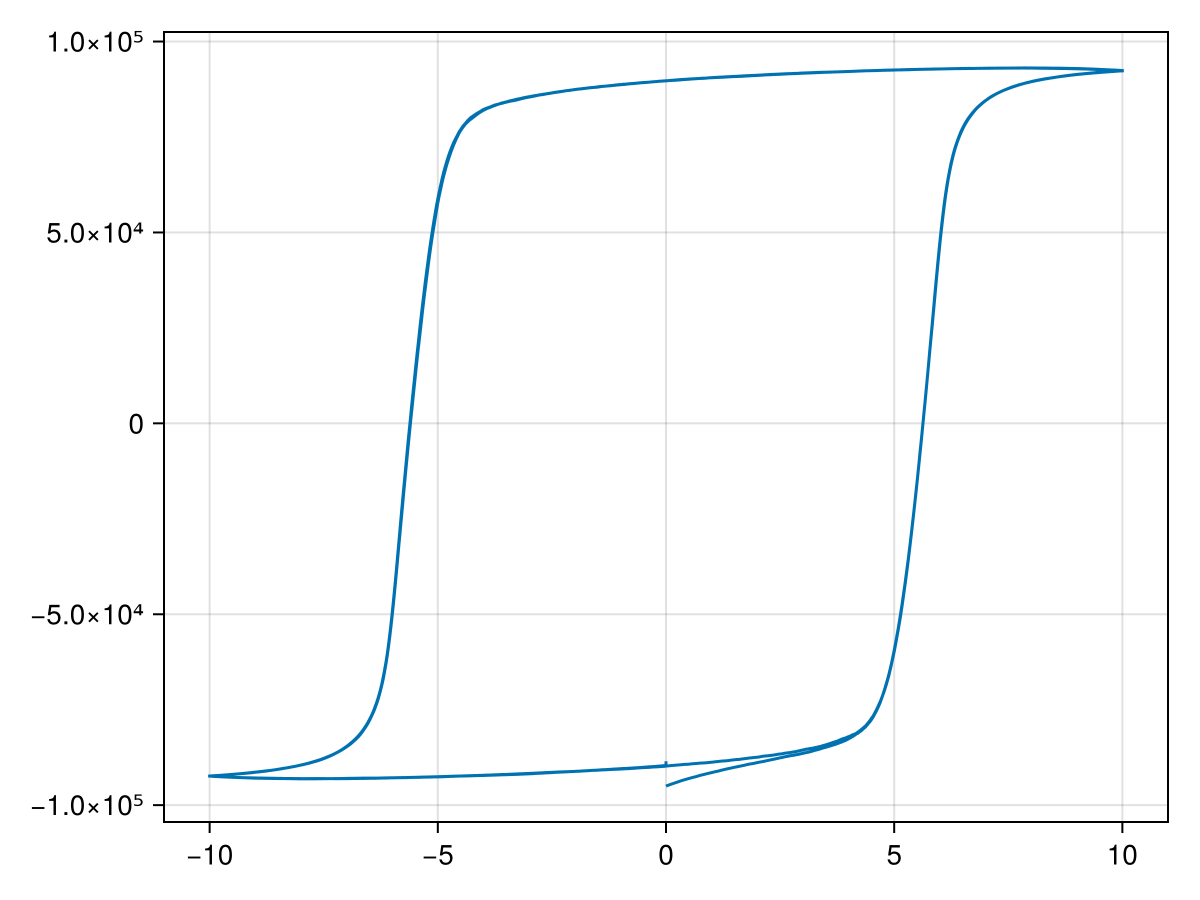

In [ ]:
### Start with TrianlePulseA.

### We are using metropolis algrithm here. 
### fullsweep means: After xL*yL*zL updates, all dipoles are updated once.
### Time_fctr means: updating speed. Somehow this factor is relatived to real time
fullsweep = xL*yL*zL
Time_fctr = 0.2
SpeedRate = Int(Time_fctr*fullsweep)

### risepoint and Amptitude are factors from pulse
risepoint=500
Amptitude =10
# risepoint = round(Int, Amptitude/0.01)

### Run with TrianlePulseA
###  /\
### /  \    _____
###     \  /
###      \/

PulseN = 2
Pulsetime = (PulseN * 4 + 2) * risepoint * SpeedRate

compalgo = CompositeAlgorithm((Metropolis, TrianglePulseA), (1, SpeedRate))
createProcess(g, compalgo, lifetime =Pulsetime, amp = Amptitude, numpulses = PulseN, rise_point=risepoint)
### estimate time
est_remaining(process(g))

# Wait until it is done
args = process(g) |> fetch # If you want to close ctr+c
# args = process(g) |> getcontext
# EnergyG= args.all_Es;
voltage= args.x
Pr= args.y;

# w1=newmakie(lines, Pr, EnergyG)
inlineplot() do 
    lines(voltage, Pr)
end
w2=newmakie(lines, voltage, Pr)
w3=newmakie(lines,Pr)


In [ ]:
### See Edp kill Pr

wg1 = @WG "(dx,dy,dz,x,y,z) -> weightfunc1(dx,dy,dz,1,1,1)" NN = (1,1,1)
genAdj!(g[1], wg1)

### We set Temperature to 1.5
settemp(g,1.5)

### Set the depolarizaition (DP) facter c=10000. Now C is more closer to 0 represents higher effects from DP
g.hamiltonian = Ising(g) + DepolField(g, c=5000, left_layers = 1, right_layers = 1)
g.hamiltonian = sethomogeneousparam(g.hamiltonian, :b)


### We are using metropolis algrithm here. 
### fullsweep means: After xL*yL*zL updates, all dipoles are updated once.
### Time_fctr means: updating speed. Somehow this factor is relatived to real time
fullsweep = xL*yL*zL
Time_fctr = 0.2
SpeedRate = Int(Time_fctr*fullsweep)

### risepoint and Amptitude are factors from pulse
risepoint=500
Amptitude =0
# risepoint = round(Int, Amptitude/0.01)

### Run with TrianlePulseA
###  /\
### /  \    _____
###     \  /
###      \/

PulseN = 2
Pulsetime = (PulseN * 4 + 15) * risepoint * SpeedRate

compalgo = CompositeAlgorithm((Metropolis, TrianglePulseA), (1, SpeedRate))
createProcess(g, compalgo, lifetime =Pulsetime, amp = Amptitude, numpulses = PulseN, rise_point=risepoint)
### estimate time
est_remaining(process(g))

# Wait until it is done
args = process(g) |> fetch # If you want to close ctr+c
# args = process(g) |> getcontext
# EnergyG= args.all_Es;
voltage= args.x
Pr= args.y;

# w1=newmakie(lines, Pr, EnergyG)
w2=newmakie(lines, voltage, Pr)
w3=newmakie(lines,Pr)


In [ ]:
### Change neraest neigbours
####################################################################################
wg1 = @WG "(dx,dy,dz,x,y,z) -> weightfunc1(dx,dy,dz,1,1,1)" NN = (2,2,2)
####################################################################################
genAdj!(g[1], wg1)
settemp(g,0)
g.hamiltonian = Ising(g) + DepolField(g, c=10000, left_layers = 1, right_layers = 1)
g.hamiltonian = sethomogeneousparam(g.hamiltonian, :b)

fullsweep = xL*yL*zL
Time_fctr = 0.5
SpeedRate = Int(Time_fctr*fullsweep)
risepoint=500
Amptitude =20
# risepoint = round(Int, Amptitude/0.01)

#### Run with TrianlePulseA
PulseN = 2
Pulsetime = (PulseN * 4 + 2) * risepoint * SpeedRate
compalgo = CompositeAlgorithm((Metropolis, TrianglePulseA), (1, SpeedRate))
createProcess(g, compalgo, lifetime =Pulsetime, amp = Amptitude, numpulses = PulseN, rise_point=risepoint)
### estimate time
est_remaining(process(g))

# Wait until it is done
args = process(g) |> fetch # If you want to close ctr+c
# args = process(g) |> getcontext
# EnergyG= args.all_Es;
voltage= args.x
Pr= args.y;

# w1=newmakie(lines, Pr, EnergyG)
w2=newmakie(lines, voltage, Pr)
w3=newmakie(lines,Pr)

In [ ]:
### Change temperature. We can try 0,5,10,20

wg1 = @WG "(dx,dy,dz,x,y,z) -> weightfunc1(dx,dy,dz,1,1,1)" NN = (1,1,1)
genAdj!(g[1], wg1)
####################################################################################
settemp(g,0)
####################################################################################
g.hamiltonian = Ising(g) + DepolField(g, c=10000, left_layers = 1, right_layers = 1)
g.hamiltonian = sethomogeneousparam(g.hamiltonian, :b)

fullsweep = xL*yL*zL
Time_fctr = 1
SpeedRate = Int(Time_fctr*fullsweep)
risepoint=500
Amptitude =10
# risepoint = round(Int, Amptitude/0.01)

#### Run with TrianlePulseA
PulseN = 2
Pulsetime = (PulseN * 4 + 2) * risepoint * SpeedRate
compalgo = CompositeAlgorithm((Metropolis, TrianglePulseA), (1, SpeedRate))
createProcess(g, compalgo, lifetime =Pulsetime, amp = Amptitude, numpulses = PulseN, rise_point=risepoint)
### estimate time
est_remaining(process(g))

# Wait until it is done
args = process(g) |> fetch # If you want to close ctr+c
# args = process(g) |> getcontext
# EnergyG= args.all_Es;
voltage= args.x
Pr= args.y;

# w1=newmakie(lines, Pr, EnergyG)
w2=newmakie(lines, voltage, Pr)
w3=newmakie(lines,Pr)


In [ ]:
### Change DP factor c, from 10000 to 5000 -> pinched loops
### Change DP factor c, from 10000 to 500 -> No ferroelectricity

wg1 = @WG "(dx,dy,dz,x,y,z) -> weightfunc1(dx,dy,dz,1,1,1)" NN = (1,1,1)
genAdj!(g[1], wg1)
settemp(g,1.5)
####################################################################################
g.hamiltonian = Ising(g) + DepolField(g, c=5000, left_layers = 1, right_layers = 1)
####################################################################################
g.hamiltonian = sethomogeneousparam(g.hamiltonian, :b)

fullsweep = xL*yL*zL
Time_fctr = 1
SpeedRate = Int(Time_fctr*fullsweep)
risepoint=500
Amptitude =10
# risepoint = round(Int, Amptitude/0.01)

#### Run with TrianlePulseA
PulseN = 2
Pulsetime = (PulseN * 4 + 2) * risepoint * SpeedRate
compalgo = CompositeAlgorithm((Metropolis, TrianglePulseA), (1, SpeedRate))
createProcess(g, compalgo, lifetime =Pulsetime, amp = Amptitude, numpulses = PulseN, rise_point=risepoint)
### estimate time
est_remaining(process(g))

# Wait until it is done
args = process(g) |> fetch # If you want to close ctr+c
# args = process(g) |> getcontext
# EnergyG= args.all_Es;
voltage= args.x
Pr= args.y;

# w1=newmakie(lines, Pr, EnergyG)
w2=newmakie(lines, voltage, Pr)
w3=newmakie(lines,Pr)

In [ ]:
### Change Jx Jy and Jz, by changing distance from (1,1,1) to (3,3,1) and (1,1,1) to (1,1,3)
### The system's ability to resist the influence of the depolarization field has deteriorated.

####################################################################################
wg1 = @WG "(dx,dy,dz,x,y,z) -> weightfunc1(dx,dy,dz,1,1,2)" NN = (1,1,1)
wg2 = @WG "(dx,dy,dz,x,y,z) -> weightfunc1(dx,dy,dz,2,2,1)" NN = (1,1,1)
        #
        #       In plane->                                           O
        #  Out of         O                     O                    |
        #   plane         |                     |                    |
        #    ↑       O —— O —— O        O —— —— O —— —— O       O —— O —— O
        #                 |                     |                    |
        #                 O                     O                    |
        #                                                            O
genAdj!(g[1], wg2)
####################################################################################

settemp(g,1.5)
g.hamiltonian = Ising(g) + DepolField(g, c=10000, left_layers = 1, right_layers = 1)
g.hamiltonian = sethomogeneousparam(g.hamiltonian, :b)

fullsweep = xL*yL*zL
Time_fctr = 1
SpeedRate = Int(Time_fctr*fullsweep)
risepoint=500
Amptitude =10
# risepoint = round(Int, Amptitude/0.01)

#### Run with TrianlePulseA
PulseN = 2
Pulsetime = (PulseN * 4 + 2) * risepoint * SpeedRate
compalgo = CompositeAlgorithm((Metropolis, TrianglePulseA), (1, SpeedRate))
createProcess(g, compalgo, lifetime =Pulsetime, amp = Amptitude, numpulses = PulseN, rise_point=risepoint)
### estimate time
est_remaining(process(g))

# Wait until it is done
args = process(g) |> fetch # If you want to close ctr+c
# args = process(g) |> getcontext
# EnergyG= args.all_Es;
voltage= args.x
Pr= args.y;

# w1=newmakie(lines, Pr, EnergyG)
w2=newmakie(lines, voltage, Pr)
w3=newmakie(lines,Pr)


In [ ]:
### We can simulate different Phase (rx ry rz distance)
### Change temperature
### Change DP factor c
### Change ampititude from 10 to 2

wg1 = @WG "(dx,dy,dz,x,y,z) -> weightfunc1(dx,dy,dz,3,3,1)" NN = (1,1,1)
genAdj!(g[1], wg1)
settemp(g,1.5)
g.hamiltonian = Ising(g) + DepolField(g, c=50000, left_layers = 1, right_layers = 1)
g.hamiltonian = sethomogeneousparam(g.hamiltonian, :b)
fullsweep = xL*yL*zL
SpeedRate = Int(1*fullsweep)
risepoint=500
Amptitude =20
# risepoint = round(Int, Amptitude/0.01)

#### Run with TrianlePulseA
PulseN = 2
Pulsetime = (PulseN * 4 + 2) * risepoint * SpeedRate

compalgo = CompositeAlgorithm((Metropolis, TrianglePulseA), (1, SpeedRate))
createProcess(g, compalgo, lifetime =Pulsetime, amp = Amptitude, numpulses = PulseN, rise_point=risepoint)
#估计时间
est_remaining(process(g))


# Wait until it is done
args = process(g) |> fetch # If you want to close ctr+c
# args = process(g) |> getcontext
# EnergyG= args.all_Es;
voltage= args.x
Pr= args.y;

# w1=newmakie(lines, Pr, EnergyG)
w2=newmakie(lines, voltage, Pr)
w3=newmakie(lines,Pr)

In [ ]:
#### Now lets do multiple values in dipoles (spins)
#### Also we can do coutinuous mode derictly

xL = 100
yL = 100
zL = 10
### Now we are using condinous value
# g = IsingGraph(xL, yL, zL, type = Discrete, periodic = (:x,:y), sets = [(-1,-0.5,0,0.5,1)] )
g = IsingGraph(xL, yL, zL, type = Continuous, periodic = (:x,:y))
init(Metropolis(), (;g))
#Set the Makie spot size to 0.3.
II.makie_markersize[] = 0.3
interface(g)

In [ ]:
### Check all values of dipoles 
state(g)

In [ ]:
### Similar results from discrete mode.
### all the previous results are similar.

wg1 = @WG "(dx,dy,dz,x,y,z) -> weightfunc1(dx,dy,dz,1,1,1)" NN = (1,1,1)
genAdj!(g[1], wg1)
settemp(g,1.5)
g.hamiltonian = Ising(g) + DepolField(g, c=10000, left_layers = 1, right_layers = 1)
g.hamiltonian = sethomogeneousparam(g.hamiltonian, :b)

fullsweep = xL*yL*zL
Time_fctr = 1
SpeedRate = Int(Time_fctr*fullsweep)
risepoint=500
Amptitude =10
# risepoint = round(Int, Amptitude/0.01)

#### Run with TrianlePulseA
PulseN = 2
Pulsetime = (PulseN * 4 + 2) * risepoint * SpeedRate
compalgo = CompositeAlgorithm((Metropolis, TrianglePulseA), (1, SpeedRate))
createProcess(g, compalgo, lifetime =Pulsetime, amp = Amptitude, numpulses = PulseN, rise_point=risepoint)
### estimate time
est_remaining(process(g))

# Wait until it is done
args = process(g) |> fetch # If you want to close ctr+c
# args = process(g) |> getcontext
# EnergyG= args.all_Es;
voltage= args.x
Pr= args.y;

# w1=newmakie(lines, Pr, EnergyG)
w2=newmakie(lines, voltage, Pr)
w3=newmakie(lines,Pr)

In [ ]:
#### Now lets do spin glass!
#### 

xL = 100
yL = 100
zL = 10
### Now we are using condinous value
# g = IsingGraph(xL, yL, zL, type = Discrete, periodic = (:x,:y), sets = [(-1,-0.5,0,0.5,1)] )
g = IsingGraph(xL, yL, zL, type = Continuous, periodic = (:x,:y))
init(Metropolis(), (;g))
#Set the Makie spot size to 0.3.
II.makie_markersize[] = 0.3
interface(g)

In [ ]:
### Start with spin glass


# x_n = uniform_partition(100, 10)
# y_n = uniform_partition(100, 10)
# z_n = uniform_partition(10, 2)


In [ ]:
### Results from random_partition domians

settemp(g,1.5)
g.hamiltonian = Ising(g) + DepolField(g, c=100, left_layers = 1, right_layers = 1)
g.hamiltonian = sethomogeneousparam(g.hamiltonian, :b)

fullsweep = xL*yL*zL
Time_fctr = 1
SpeedRate = Int(Time_fctr*fullsweep)
risepoint=500
Amptitude =1000
# risepoint = round(Int, Amptitude/0.01)

#### Run with TrianlePulseA
PulseN = 2
Pulsetime = (PulseN * 4 + 2) * risepoint * SpeedRate
compalgo = CompositeAlgorithm((Metropolis, TrianglePulseA), (1, SpeedRate))
createProcess(g, compalgo, lifetime =Pulsetime, amp = Amptitude, numpulses = PulseN, rise_point=risepoint)
### estimate time
est_remaining(process(g))

# Wait until it is done
args = process(g) |> fetch # If you want to close ctr+c
# args = process(g) |> getcontext
# EnergyG= args.all_Es;
voltage= args.x
Pr= args.y;

# w1=newmakie(lines, Pr, EnergyG)
w2=newmakie(lines, voltage, Pr)
w3=newmakie(lines,Pr)

In [ ]:
### We can also do uniform domians

x_n = uniform_partition(100, 20)
y_n = uniform_partition(100, 20)
z_n = uniform_partition(10, 2)
# x_n = random_partition(xL, 20)
# y_n = random_partition(yL, 20)
# z_n = random_partition(zL, 3)
coef_x =randAround(1, 0.2, 20)
coef_y =randAround(1, 0.2, 20)
coef_z =randAround(1, 0.2, 3)
println(x_n)
println(y_n)
println(z_n)
println(coef_x)
println(coef_y)
println(coef_z)
wg_glass1 = @WG "(dx,dy,dz,x,y,z) -> weightfunc_glass_ferro(dx,dy,dz,x,y,z,x_n, y_n, z_n, coef_x,coef_y,coef_z)" NN = (1,1,1)
wg_glass2 = @WG "(dx,dy,dz,x,y,z) -> weightfunc_glass_anti(dx,dy,dz,x,y,z, x_n, y_n, z_n, coef_x,coef_y,coef_z)" NN = (1,1,1)
wg_glass3 = @WG "(dx,dy,dz,x,y,z) -> weightfunc_AntiWithFerro(dx, dy, dz, x, y, z, x_n, y_n, z_n, coef_x, coef_y, coef_z)" NN = (2,2,2)
genAdj!(g[1], wg_glass3)

In [ ]:
### 

settemp(g,1.5)
g.hamiltonian = Ising(g) + DepolField(g, c=1000, left_layers = 1, right_layers = 1)
g.hamiltonian = sethomogeneousparam(g.hamiltonian, :b)

fullsweep = xL*yL*zL
Time_fctr = 1
SpeedRate = Int(Time_fctr*fullsweep)
risepoint=500
Amptitude =80
# risepoint = round(Int, Amptitude/0.01)

#### Run with TrianlePulseA
PulseN = 2
Pulsetime = (PulseN * 4 + 2) * risepoint * SpeedRate
compalgo = CompositeAlgorithm((Metropolis, TrianglePulseA), (1, SpeedRate))
createProcess(g, compalgo, lifetime =Pulsetime, amp = Amptitude, numpulses = PulseN, rise_point=risepoint)
### estimate time
est_remaining(process(g))

# Wait until it is done
args = process(g) |> fetch # If you want to close ctr+c
# args = process(g) |> getcontext
# EnergyG= args.all_Es;
voltage= args.x
Pr= args.y;

# w1=newmakie(lines, Pr, EnergyG)
w2=newmakie(lines, voltage, Pr)
w3=newmakie(lines,Pr)

In [ ]:
### Defects and defects movements.
### defects moving could be also put into a metropolis loops in a metropolis cell.

xL = 100
yL = 100
zL = 10
### Now we are using condinous value
# g = IsingGraph(xL, yL, zL, type = Discrete, periodic = (:x,:y), sets = [(-1,-0.5,0,0.5,1)] )
g = IsingGraph(xL, yL, zL, type = Continuous, periodic = (:x,:y))
init(Metropolis(), (;g))
#Set the Makie spot size to 0.3.
II.makie_markersize[] = 0.3
interface(g)

In [ ]:
### We can freely add defects in the lattice
### We want to define defects as:
###     1) Pinned dipoles
###     2) 0 values dipoles

### Here we add radom defects, 3% in layer 1 and 10. they have pinned values 1 and -1
addRandomDefects!(g[1][1], 3, -1)
addRandomDefects!(g[1][1], 3, 1)
addRandomDefects!(g[1][1], 3, 0)
addRandomDefects!(g[1][10], 3, -1)
addRandomDefects!(g[1][10], 3, 1)
addRandomDefects!(g[1][10], 3, 0)


In [ ]:
### Results with defects

wg1 = @WG "(dx,dy,dz,x,y,z) -> weightfunc1(dx,dy,dz,1,1,1)" NN = (1,1,1)
genAdj!(g[1], wg1)
settemp(g,1.5)
g.hamiltonian = Ising(g) + DepolField(g, c=1000, left_layers = 1, right_layers = 1)
g.hamiltonian = sethomogeneousparam(g.hamiltonian, :b)

fullsweep = xL*yL*zL
Time_fctr = 1
SpeedRate = Int(Time_fctr*fullsweep)
risepoint=500
Amptitude =10
# risepoint = round(Int, Amptitude/0.01)

#### Run with TrianlePulseA
PulseN = 2
Pulsetime = (PulseN * 4 + 2) * risepoint * SpeedRate
compalgo = CompositeAlgorithm((Metropolis, TrianglePulseA), (1, SpeedRate))
createProcess(g, compalgo, lifetime =Pulsetime, amp = Amptitude, numpulses = PulseN, rise_point=risepoint)
### estimate time
est_remaining(process(g))

# Wait until it is done
args = process(g) |> fetch # If you want to close ctr+c
# args = process(g) |> getcontext
# EnergyG= args.all_Es;
voltage= args.x
Pr= args.y;

# w1=newmakie(lines, Pr, EnergyG)
w2=newmakie(lines, voltage, Pr)
w3=newmakie(lines,Pr)

In [ ]:
### Self energy
homogeneousself!(g, 0.2)